# Computer Vision, Image Classification - Covid CT Scans
Kyle Ziegler 4/2022

Dataset info: [Kaggle](https://www.kaggle.com/datasets/hgunraj/covidxct), 60GB, 200k images with bounding boxes and classes. 


In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.8.0
Num GPUs Available:  4


2022-04-20 16:11:42.106291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 16:11:42.107464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 16:11:42.108473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 16:11:42.109491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 16:11:42.218667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


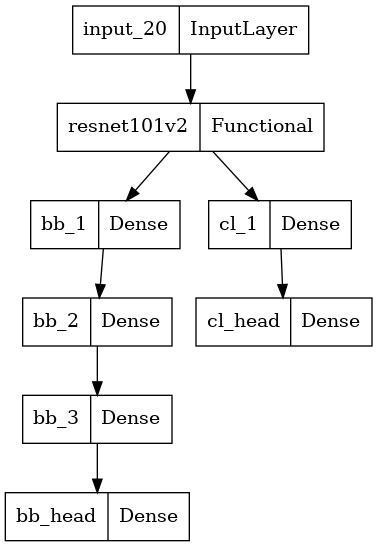

In [26]:
num_classes = 4
image_channels = 3
height, width = 300,300

from tensorflow.keras import layers

mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    def create_model():
        #create the common input layer

        input_shape = (height, width, image_channels)
        input_layer = tf.keras.layers.Input(input_shape)

        #create the base layers
        # base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
        # base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
        base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(input_layer)
        base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
        base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
        base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
        base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
        base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
        base_layers = layers.Flatten(name='bl_8')(base_layers)
        # shivaji - add your heads to a pre-built model

        #create the classifier branch
        classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
        classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)
        # logisitic regression for each posible class

        #create the localiser branch
        locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
        locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
        locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
        locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)
        # output 4 floats, MSE loss metric

        model = tf.keras.Model(input_layer, outputs=[classifier_branch,locator_branch])

        return model
    
    def create_transfer_learning_model():
        
        base_model = tf.keras.applications.ResNet101V2(
            include_top=False,
            weights="imagenet",
            input_shape=(height, width, image_channels),
            pooling="avg",
            classifier_activation=None, # only used when you are including the top
        )
        base_model.trainable = False
        
        input_shape = (height, width, image_channels)
        input_layer = tf.keras.layers.Input(input_shape)
        
        base_layers = base_model(input_layer, training=False)
        
        # base_model.add(Flatten())
        # flatten = tf.keras.layers.Flatten()(base_model.layers[-1].output)
        
        #create the classifier branch
        classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
        classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)
        # logisitic regression for each posible class

        #create the localiser branch
        locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
        locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
        locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
        locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)
        # output 4 floats, MSE loss metric

        model = tf.keras.Model(input_layer, outputs=[classifier_branch,locator_branch])

        return model

    model = create_transfer_learning_model()
    
    
tf.keras.utils.plot_model(model)


In [27]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet101v2 (Functional)       (None, 2048)         42626560    ['input_20[0][0]']               
                                                                                                  
 bb_1 (Dense)                   (None, 128)          262272      ['resnet101v2[0][0]']            
                                                                                                  
 bb_2 (Dense)                   (None, 64)           8256        ['bb_1[0][0]']             

In [28]:
# you can either define sparse categorical crossentropy here, or one hot encode the feature before getting here.
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(),
          "bb_head":tf.keras.losses.MSE
        }

metrics = {"cl_head":"accuracy",
           "bb_head": "mean_squared_error"
        }

initial_learning_rate = 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss=losses, optimizer=opt, metrics=metrics)

In [29]:
BATCH_SIZE = 256
channels = 3

def parse_record(record):
    # print(tfrec)

    feature_mapping = {
        'image': tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'bounding_box': tf.io.FixedLenFeature([4], tf.float32),  # shape [] means single element
        'target_class': tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    
    file_rec = tf.io.parse_single_example(record, feature_mapping)
    
    image = file_rec["image"]
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, (height, width))
    
    image = tf.image.convert_image_dtype(image, tf.float32) # normalizes between [0,1]
    print(image)
    
    # print(image)
    
    bounding_box = file_rec["bounding_box"]
    
    target_class = file_rec["target_class"]
    
    return image, (target_class, bounding_box)

def create_prefetch_dataset(file_path):
    print('Creating Prefetch Dataset From', file_path)

    # list_files have shuffle True by default
    dataset = tf.data.Dataset.list_files(file_path)
    
    # A note on caching with cache(), you should only use this on small datasets 
    # that fit into memory, otherwise you'll crash your machine.
    
    dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=tf.data.AUTOTUNE)\
    .map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(BATCH_SIZE, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)\
    .repeat(-1)
    
    # Repeat creates an infinite loop, but the optimizer will stop when we are not making 
    # any progress. You also set a number of epochs.

    return dataset

dataset = create_prefetch_dataset("gs://vertex-central-1f/covid_proj_tfrecords/train/TFRECORD*")
print(dataset)

Creating Prefetch Dataset From gs://vertex-central-1f/covid_proj_tfrecords/train/TFRECORD*
Tensor("Identity:0", shape=(300, 300, 3), dtype=float32)
<RepeatDataset element_spec=(TensorSpec(shape=(256, 300, 300, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(256,), dtype=tf.int64, name=None), TensorSpec(shape=(256, 4), dtype=tf.float32, name=None)))>


In [13]:
!rm -r ./logs/fit/

rm: cannot remove './logs/fit/': No such file or directory


### KZ notes on performance
- When using a batch size of 256, main mem is around 15GB used, slightly increasing over each epoch.
- CPU is around 10 cores at 100%, fluctuating between 5-11 cores.
- GPU is around 75-95% utilization, only dropping for a second between epochs. GPU mem is at

In [ ]:
import datetime
import os
# ceil(num_samples / batch_size) = 195000/256 = 400

steps = 195000//BATCH_SIZE

log_dir = os.getcwd() + '/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# code for writing profile metrics, does not work in Vertex hosted Tensorboard 4/2022
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
#                                                       histogram_freq=1,
#                                                       profile_batch = '0,10',
#                                                       write_images=False
#                                                      )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                     update_freq='epoch')
    
history = model.fit(dataset, epochs=50, steps_per_epoch=steps, initial_epoch = 0, callbacks=[tensorboard_callback])

Epoch 1/50
761/761 [==============================] - 142s 185ms/step - loss: 12.7085 - cl_head_loss: 12.1545 - bb_head_loss: 0.5539 - cl_head_accuracy: 0.2459 - bb_head_mean_squared_error: 0.5539
Epoch 2/50
761/761 [==============================] - 133s 175ms/step - loss: 12.5611 - cl_head_loss: 12.0084 - bb_head_loss: 0.5527 - cl_head_accuracy: 0.2550 - bb_head_mean_squared_error: 0.5527
Epoch 3/50
761/761 [==============================] - 136s 178ms/step - loss: 12.6104 - cl_head_loss: 12.0574 - bb_head_loss: 0.5530 - cl_head_accuracy: 0.2519 - bb_head_mean_squared_error: 0.5530
Epoch 4/50
761/761 [==============================] - 135s 177ms/step - loss: 12.7136 - cl_head_loss: 12.1603 - bb_head_loss: 0.5533 - cl_head_accuracy: 0.2455 - bb_head_mean_squared_error: 0.5533
Epoch 5/50
761/761 [==============================] - 133s 175ms/step - loss: 12.6273 - cl_head_loss: 12.0736 - bb_head_loss: 0.5537 - cl_head_accuracy: 0.2509 - bb_head_mean_squared_error: 0.5537
Epoch 6/50
761/

In [22]:
%%bash
tb-gcp-uploader --tensorboard_resource_name \
  projects/156596422468/locations/us-central1/tensorboards/3919064061672685568 \
  --logdir=/home/jupyter/covid-proj/logs \
  --experiment_name=model-fit --one_shot=True

View your Tensorboard at https://us-central1.tensorboard.googleusercontent.com/experiment/projects+156596422468+locations+us-central1+tensorboards+3919064061672685568+experiments+model-fit
[2022-04-18T22:25:09] Started scanning logdir.
[2022-04-18T22:25:59] Total uploaded: 90 scalars, 648 tensors (232.6 kB), 6 binary objects (513.0 kB)


2022-04-18 22:25:06.756706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 22:25:06.766530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 22:25:06.766860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
W0418 22:25:09.727760 139985401202496 uploader.py:379] Please consider uploading to a new experiment instead of an existing one, as the former allows for better upload performance.


In [32]:
print(history)

In [34]:
model.save('saved_model/my_model')

2022-04-20 19:35:52.327380: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/my_model/assets
